# Laboratorio 2 - Series de tiempo

* Mariana David 201055


In [45]:
#importamos las librerías necesarias para trabajar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import acf, plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import statsmodels.api as sm

import datetime

ModuleNotFoundError: No module named 'statsmodels'

Leemos .csv 

In [23]:
import pandas as pd

# Unir los datasets de precios 
precios_2021 = pd.read_csv('Precios_Promedio2021.csv')
precios_2022 = pd.read_csv('Precios_Promedio2022.csv')
precios_2023 = pd.read_csv('Precios_Promedio2023.csv')
importaciones = pd.read_csv("imp_vol.csv")

#Unimos precios
precios_prom = pd.concat([precios_2021, precios_2022, precios_2023])

#Eliminamos datos que no nos sirven
precios_prom.drop(["Bunker", "Tipo de Cambio"], axis=1, inplace=True)


In [93]:
#consumos data
consumos = pd.read_csv('consumo.csv')

***Análisis exploratorio***

Creamos una función que determina, como vector, las fechas de cada registro en los datos. Luego, se sobreescribe esta columna en el *dataframe*, con el fin de manejarlo más adelante dentro de las gráficas y el estudio de los datos.

In [20]:
def formato_fecha(df):
    fechas = []
    for i in range(0, len(df)):
        fecha = str(datetime.date(int(df["Anio"][i]), int(df["Mes"][i]), 1))
        fechas.append(fecha)
    
    df["Fechas"] = fechas

Para el dataframe **datos importaciones combustibles**, puede observarse que se cuenta con 245 filas y 29 columnas, dentro de las cuales existe una cantidad considerable de datos no disponibles (NaN). En particular, a primera vista esto es evidente para las columnas de "DieselLS", "DieselULS", "Solventes", "Naftas", "Ceras", "Butano", "Orimulsion", "MezclasOleosas" y "PetroleoCrudo".

In [21]:
importaciones

Fecha  Aceites lubricantes   Asfalto     Bunker   Ceras  \
0    2000-01-01 00:00:00                 0.00  48446.00  296766.99    0.00   
1    2000-02-01 00:00:00                 0.00  50597.00  328116.44    0.00   
2    2000-03-01 00:00:00                 0.00  27593.00  368589.63    0.00   
3    2000-04-01 00:00:00                 0.00  53794.00  396300.47    0.00   
4    2000-05-01 00:00:00                 0.00  60137.00  449368.92    0.00   
..                   ...                  ...       ...        ...     ...   
276  2023-01-01 00:00:00             26561.43  77035.87  105294.71 -380.72   
277  2023-02-01 00:00:00             25743.23  74416.24  116577.42 -287.62   
278  2023-03-01 00:00:00             31025.18  69630.40  194492.83     NaN   
279  2023-04-01 00:00:00             22208.24  74654.67  157844.83 -841.64   
280  2023-05-01 00:00:00             25230.27  76296.87  221002.66 -797.34   

     Combustible turbo jet  Diesel bajo azufre  Diesel ultra bajo azufre  \
0                     0.00                0.00                      0.00   
1                     0.00                0.00                      0.00   
2                     0.00                0.00                      0.00   
3                     0.00                0.00                      0.00   
4                     0.00                0.00                      0.00   
..                     ...                 ...                       ...   
276               73581.22          1285932.51                   9391.16   
277               66761.16          1226884.63                   8398.95   
278               83431.51          1463008.43                  11462.71   
279               80733.64          1248429.37                  10553.37   
280               73860.95          1346554.12                  12201.45   

     Gas licuado de petróleo  Gasolina de aviación  ...  Kerosina  \
0              194410.476190               1426.00  ...  64026.09   
1              174710.552381               1458.00  ...  62660.30   
2              189234.066667               1503.00  ...  61361.99   
3              174330.607143               1561.00  ...  61814.32   
4              191745.147619               1642.00  ...  54098.32   
..                       ...                   ...  ...       ...   
276            574148.000000               1224.04  ...    540.21   
277            497273.190000               1134.43  ...    935.55   
278            588892.160000               1514.78  ...  -1882.43   
279            513919.890000               1390.03  ...  -1568.78   
280            565814.790000               1790.83  ...  -2825.20   

     Mezclas oleosas  Naftas    PetCoke  Petróleo crudo  Solventes  Butano  \
0               0.00    0.00       0.00            0.00       0.00     0.0   
1               0.00    0.00       0.00            0.00       0.00     0.0   
2               0.00    0.00       0.00            0.00       0.00     0.0   
3               0.00    0.00       0.00            0.00       0.00     0.0   
4               0.00    0.00       0.00            0.00       0.00     0.0   
..               ...     ...        ...             ...        ...     ...   
276          2222.59  142.63  427535.42       112435.87    7647.92     0.0   
277          1133.80  145.61  311098.09       100237.67   16166.19     0.0   
278          2024.49  268.68  311475.22       112090.14   12781.27     0.0   
279           940.32  108.23  322290.11        96434.73   13410.95     0.0   
280          1652.70  325.27  508981.62       114448.93   15206.96     0.0   

     Diesel alto azufre  Orimulsión         Total  
0             634667.06           0  1.750545e+06  
1             642380.66           0  1.773220e+06  
2             699807.25           0  1.909499e+06  
3             586803.98           0  1.800933e+06  
4             656948.20           0  1.941772e+06  
..                  ...         ...           ...  
276                0.00           0  4.

Observación de datos 

In [35]:
#datos contenido
precios_prom.head()


FECHA  Superior  Regular  Diesel  Glp Cilindro 25Lbs.  Unnamed: 7
0  1-ene-21     21.91    21.11   17.61                 99.0        3.96
1  2-ene-21     21.91    21.11   17.61                 99.0        3.96
2  3-ene-21     21.91    21.11   17.61                 99.0        3.96
3  4-ene-21     21.91    21.11   17.61                 99.0        3.96
4  5-ene-21     21.91    21.11   17.61                 99.0        3.96

In [34]:
#descripion de datos
precios_prom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 948 entries, 0 to 217
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   FECHA                948 non-null    object 
 1   Superior             948 non-null    float64
 2   Regular              948 non-null    float64
 3   Diesel               948 non-null    float64
 4   Glp Cilindro 25Lbs.  948 non-null    float64
 5   Unnamed: 7           948 non-null    float64
dtypes: float64(5), object(1)
memory usage: 51.8+ KB


Valoramos las variables cuantitativas

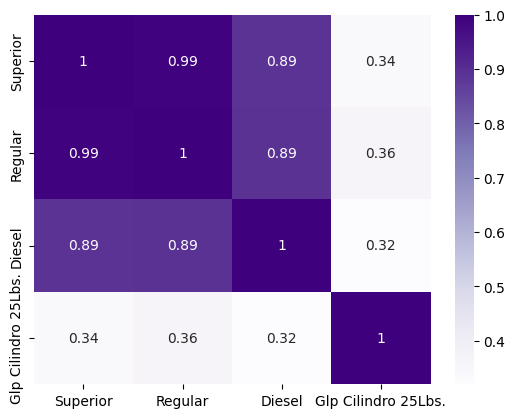

In [48]:
cuantitativas = [
    "Superior",
    "Regular",
    "Diesel",
    "Glp Cilindro 25Lbs."
]

precios_prom_cuantitativas = precios_prom[cuantitativas]
cr = precios_prom_cuantitativas.corr()
sns.heatmap(cr, annot=True, cmap="Purples")
plt.show()


c:\Users\Mariana\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\Mariana\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\Mariana\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\Mariana\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\Mariana\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable h

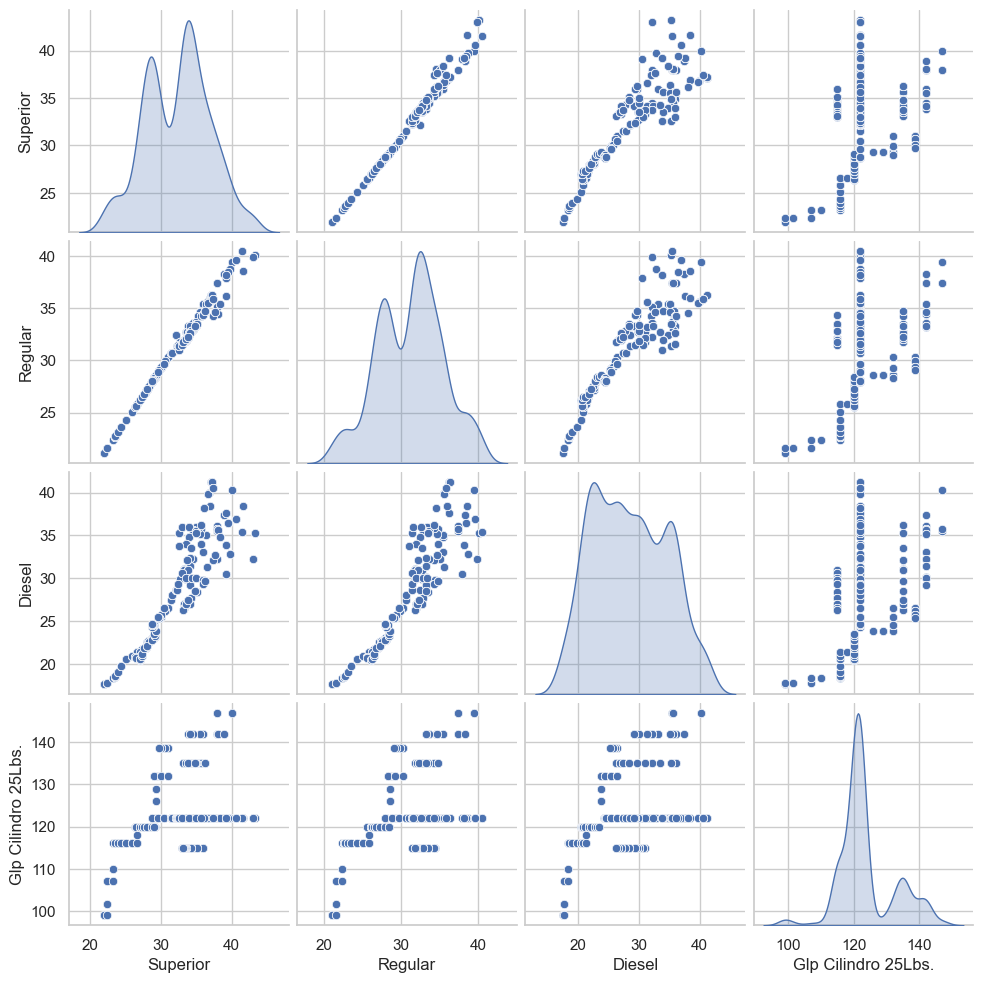

In [52]:
custom_palette = sns.color_palette("RdPu")
sns.set(style="whitegrid")  
grid = sns.pairplot(precios_prom_cuantitativas, diag_kind="kde", palette="plasma")
plt.show()

***Generamos diagrma de caja y bigotes***

2A. Consumo mensual de gasolina super

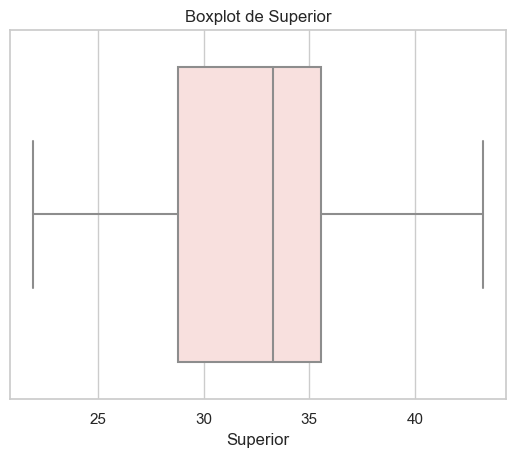

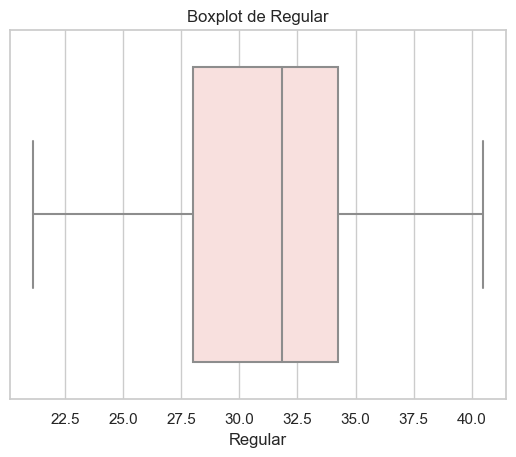

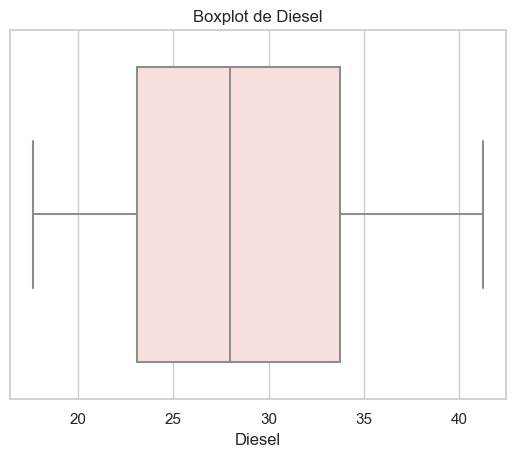

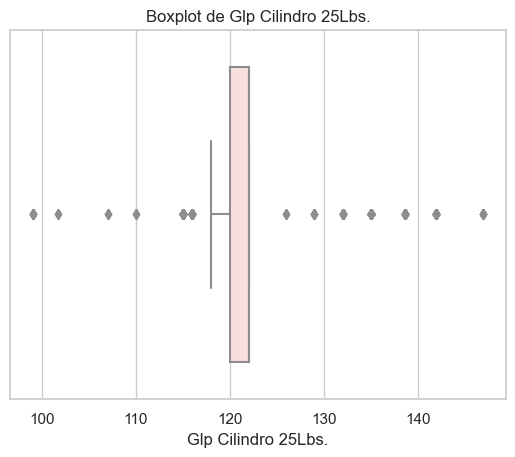

In [54]:
sns.set_style("whitegrid")  # Establece un estilo de trama con fondo blanco y cuadrícula
sns.set_palette("RdPu")      # Establece la paleta de colores en tonos rosados

for col in cuantitativas:
    sns.boxplot(x=precios_prom[col])
    plt.title(f'Boxplot de {col}')
    plt.show()

2B. Importación mensual de gasolina super gasolina regular, diésel y gas licuado


<Figure size 2000x1000 with 0 Axes>

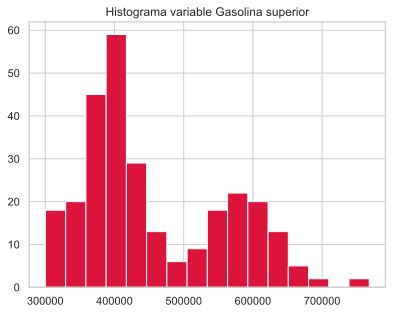

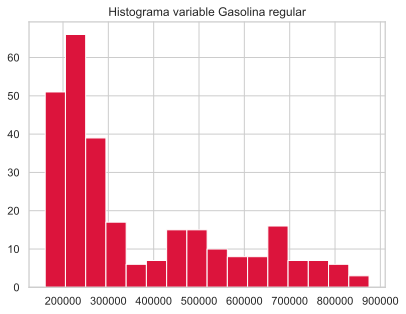

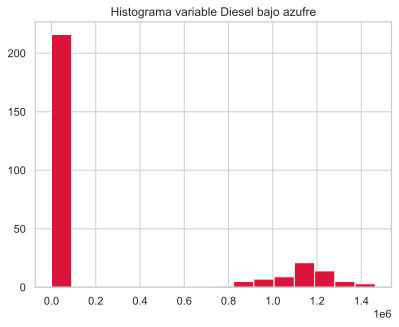

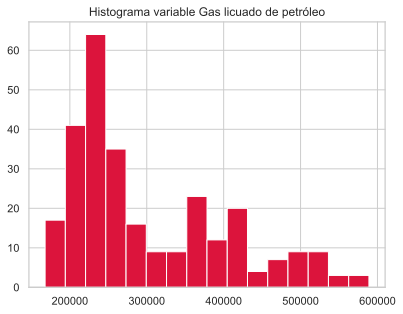

In [88]:
columnas = ["Gasolina superior", "Gasolina regular", "Diesel bajo azufre", "Gas licuado de petróleo"]
#Para consumos
fig1 = plt.figure(figsize=(20,10)) 
for k in columnas:
    importaciones.hist(k, bins = 16, color = "crimson")
    plt.title("Histograma variable " + str(k))

<Figure size 2000x1000 with 0 Axes>

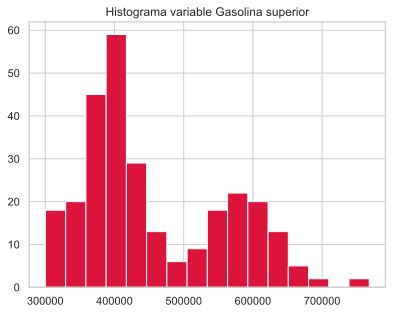

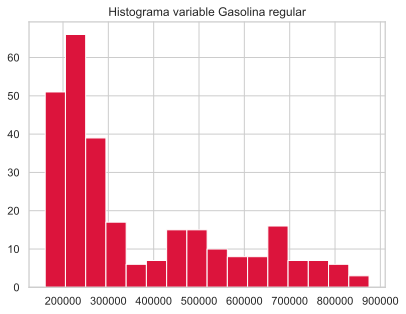

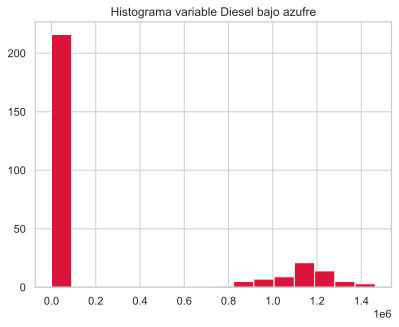

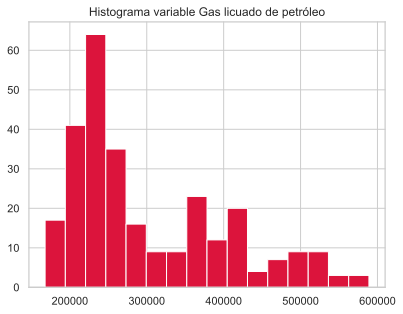

In [89]:
#Para importaciones
fig1 = plt.figure(figsize=(20,10)) 
for k in columnas:
    importaciones.hist(k, bins = 16, color = "crimson")
    plt.title("Histograma variable " + str(k))

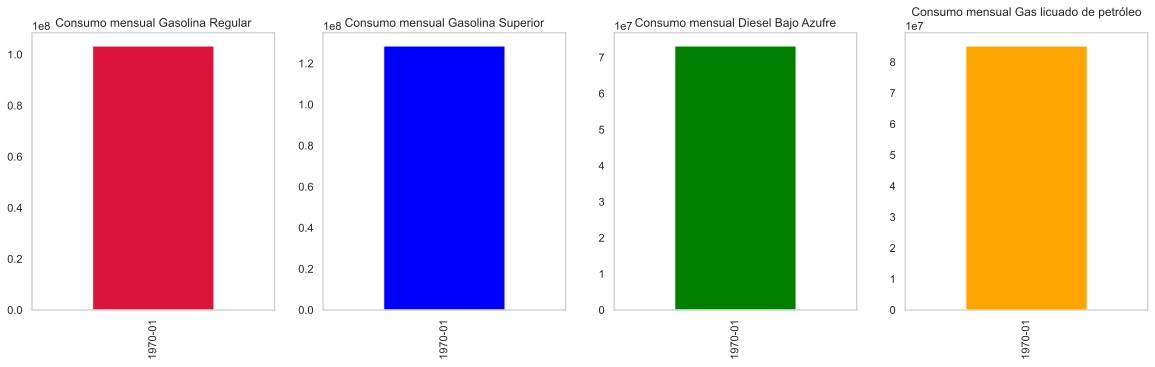

In [107]:
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import LSTM, Dense

#Comparación mensual por consumo 
columnas = "Gasolina superior", "Gasolina regular", "Diesel bajo azufre", "Gas licuado de petróleo"

consumos.index = pd.to_datetime(consumos.index)  # Convertir el índice a tipo datetime

# Comparación mensual
fig = plt.figure(figsize=(20, 5))

ax = fig.add_subplot(141)  # Subplot para Gasolina Regular
consumos.groupby(consumos.index.to_period('M'))["Gasolina regular"].sum().plot.bar(color="crimson")
ax.set_title("Consumo mensual Gasolina Regular")
plt.grid()

ax = fig.add_subplot(142)  # Subplot para Gasolina Superior
consumos.groupby(consumos.index.to_period('M'))["Gasolina superior"].sum().plot.bar(color="blue")
ax.set_title("Consumo mensual Gasolina Superior")
plt.grid()

ax = fig.add_subplot(143)  # Subplot para Diesel Bajo Azufre
consumos.groupby(consumos.index.to_period('M'))["Diesel bajo azufre"].sum().plot.bar(color="green")
ax.set_title("Consumo mensual Diesel Bajo Azufre")
plt.grid()

ax = fig.add_subplot(144)  # Subplot para Gas licuado de petróleo
consumos.groupby(consumos.index.to_period('M'))["Gas licuado de petróleo"].sum().plot.bar(color="orange")
ax.set_title("Consumo mensual Gas licuado de petróleo")
plt.grid()

plt.tight_layout
()
plt.show()


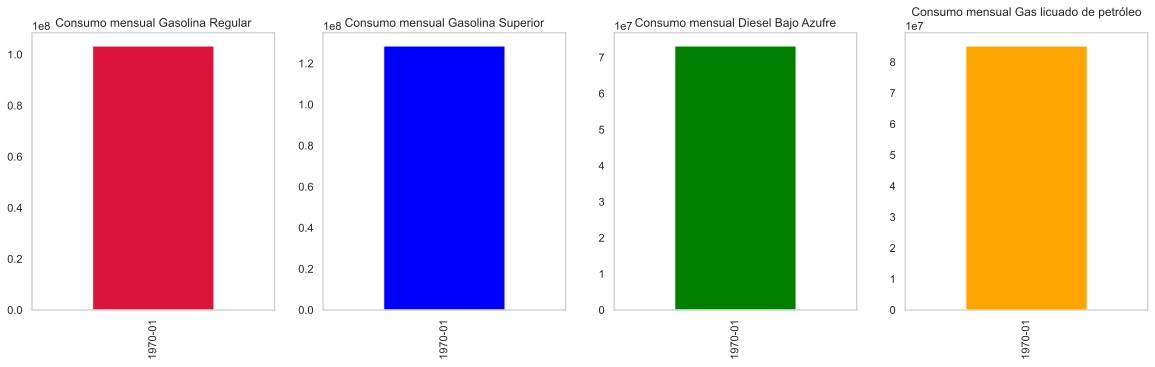

In [108]:


import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import LSTM, Dense

#Comparación mensual por consumo 
columnas = "Gasolina superior", "Gasolina regular", "Diesel bajo azufre", "Gas licuado de petróleo"

importaciones.index = pd.to_datetime(importaciones.index)  # Convertir el índice a tipo datetime

# Comparación mensual
fig = plt.figure(figsize=(20, 5))

ax = fig.add_subplot(141)  # Subplot para Gasolina Regular
importaciones.groupby(importaciones.index.to_period('M'))["Gasolina regular"].sum().plot.bar(color="crimson")
ax.set_title("Importaciones mensual Gasolina Regular")
plt.grid()

ax = fig.add_subplot(142)  # Subplot para Gasolina Superior
importaciones.groupby(importaciones.index.to_period('M'))["Gasolina superior"].sum().plot.bar(color="blue")
ax.set_title("Importaciones mensual Gasolina Superior")
plt.grid()

ax = fig.add_subplot(143)  # Subplot para Diesel Bajo Azufre
importaciones.groupby(importaciones.index.to_period('M'))["Diesel bajo azufre"].sum().plot.bar(color="green")
ax.set_title("Importaciones mensual Diesel Bajo Azufre")
plt.grid()

ax = fig.add_subplot(144)  # Subplot para Gas licuado de petróleo
importaciones.groupby(importaciones.index.to_period('M'))["Gas licuado de petróleo"].sum().plot.bar(color="orange")
ax.set_title("Importaciones mensual Gas licuado de petróleo")
plt.grid()

plt.tight_layout
()
plt.show()



Inicialmente, el consumo mensual de gasolina regular muestra una estabilidad en su patrón.

En cuanto al consumo mensual de gasolina superior, se nota un pequeño cambio.

Por otro lado, el consumo mensual de gasolina diesel es más variable y alto, posiblemente debido a su uso en transporte pesado y su disponibilidad económica.  

Finalmente en el gas de petroleo vemos que es que tiene un valor mayor significando que es el mas sobresaliente de los entes comparativos.

2C. Precios en ciudad capital de gasolina super, gasolina regular, diésel y gas licuado

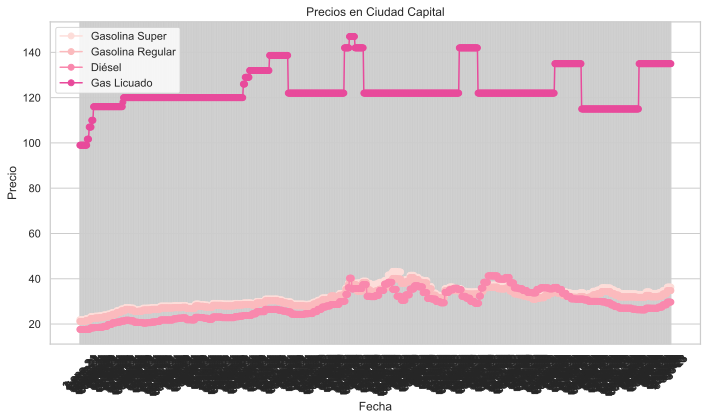

In [127]:
import matplotlib.pyplot as plt

# Datos de ejemplo (reemplaza esto con tus datos reales)
fechas = precios_prom["FECHA"]
precio_super = precios_prom["Superior"]
precio_regular = precios_prom["Regular"]
precio_diesel = precios_prom["Diesel"]
precio_glp = precios_prom["Glp Cilindro 25Lbs."]

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.plot(fechas, precio_super, marker='o', label='Gasolina Super')
plt.plot(fechas, precio_regular, marker='o', label='Gasolina Regular')
plt.plot(fechas, precio_diesel, marker='o', label='Diésel')
plt.plot(fechas, precio_glp, marker='o', label='Gas Licuado')

# Etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.title('Precios en Ciudad Capital')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()


***3.De cada serie de las seleccionadas:***

a. Especifique Inicio, fin, y frecuencia.

C:\Users\Mariana\AppData\Local\Temp\ipykernel_9060\433053152.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.plot(importaciones["Fecha"], importaciones[producto], color=plt.cm.get_cmap('tab10')(i))


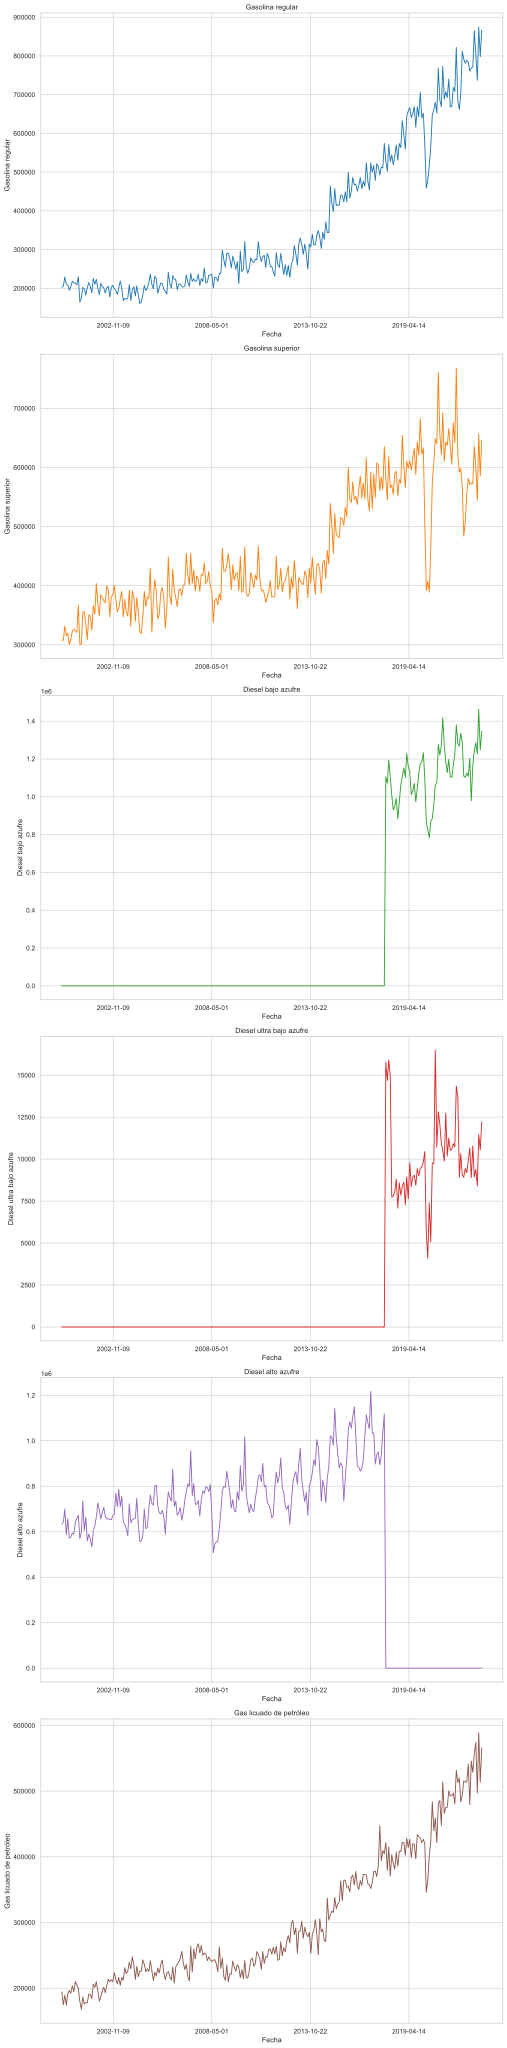

Inicio de la serie: 2000-01-01 00:00:00
Fin de la serie: 2023-05-01 00:00:00
Frecuencia:  31.0


In [170]:
import matplotlib.pyplot as plt
import pandas as pd

# Carga de datos
importaciones = pd.read_csv("imp_vol.csv")

# Convertir la columna "Fecha" a formato de datetime
importaciones["Fecha"] = pd.to_datetime(importaciones["Fecha"])

productos = ["Gasolina regular", "Gasolina superior", "Diesel bajo azufre", "Diesel ultra bajo azufre", "Diesel alto azufre", "Gas licuado de petróleo"]

fig, axes = plt.subplots(nrows=len(productos), figsize=(12, 8 * len(productos)))

for i, producto in enumerate(productos):
    ax = axes[i]
    ax.plot(importaciones["Fecha"], importaciones[producto], color=plt.cm.get_cmap('tab10')(i))
    ax.set_xlabel('Fecha')
    ax.set_ylabel(producto)
    ax.set_title(producto)
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))  # Mostrar un máximo de 6 fechas en el eje x

plt.tight_layout()
plt.show()

# Obtener el inicio y fin de la serie
inicio = importaciones["Fecha"].min()
fin = importaciones["Fecha"].max()

print('Inicio de la serie:', inicio)
print('Fin de la serie:', fin)

# Calcular las diferencias entre las fechas
diferencias = importaciones["Fecha"].diff().dt.days

# Encontrar el valor más común
frecuencia = diferencias.value_counts().idxmax()

print("Frecuencia: ", frecuencia)


b. Haga un gráfico de la serie y explique qué información puede obtener a primera vista.

C:\Users\Mariana\AppData\Local\Temp\ipykernel_9060\1544133396.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(plt.FixedFormatter(fechas.dt.strftime("%Y-%m-%d")))  # Formato de fechas
C:\Users\Mariana\AppData\Local\Temp\ipykernel_9060\1544133396.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(plt.FixedFormatter(fechas.dt.strftime("%Y-%m-%d")))  # Formato de fechas
C:\Users\Mariana\AppData\Local\Temp\ipykernel_9060\1544133396.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(plt.FixedFormatter(fechas.dt.strftime("%Y-%m-%d")))  # Formato de fechas
C:\Users\Mariana\AppData\Local\Temp\ipykernel_9060\1544133396.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(plt.FixedFormatter(fechas.dt.strftime("%Y-%m-%d")))  # Formato de fechas
C:\Users

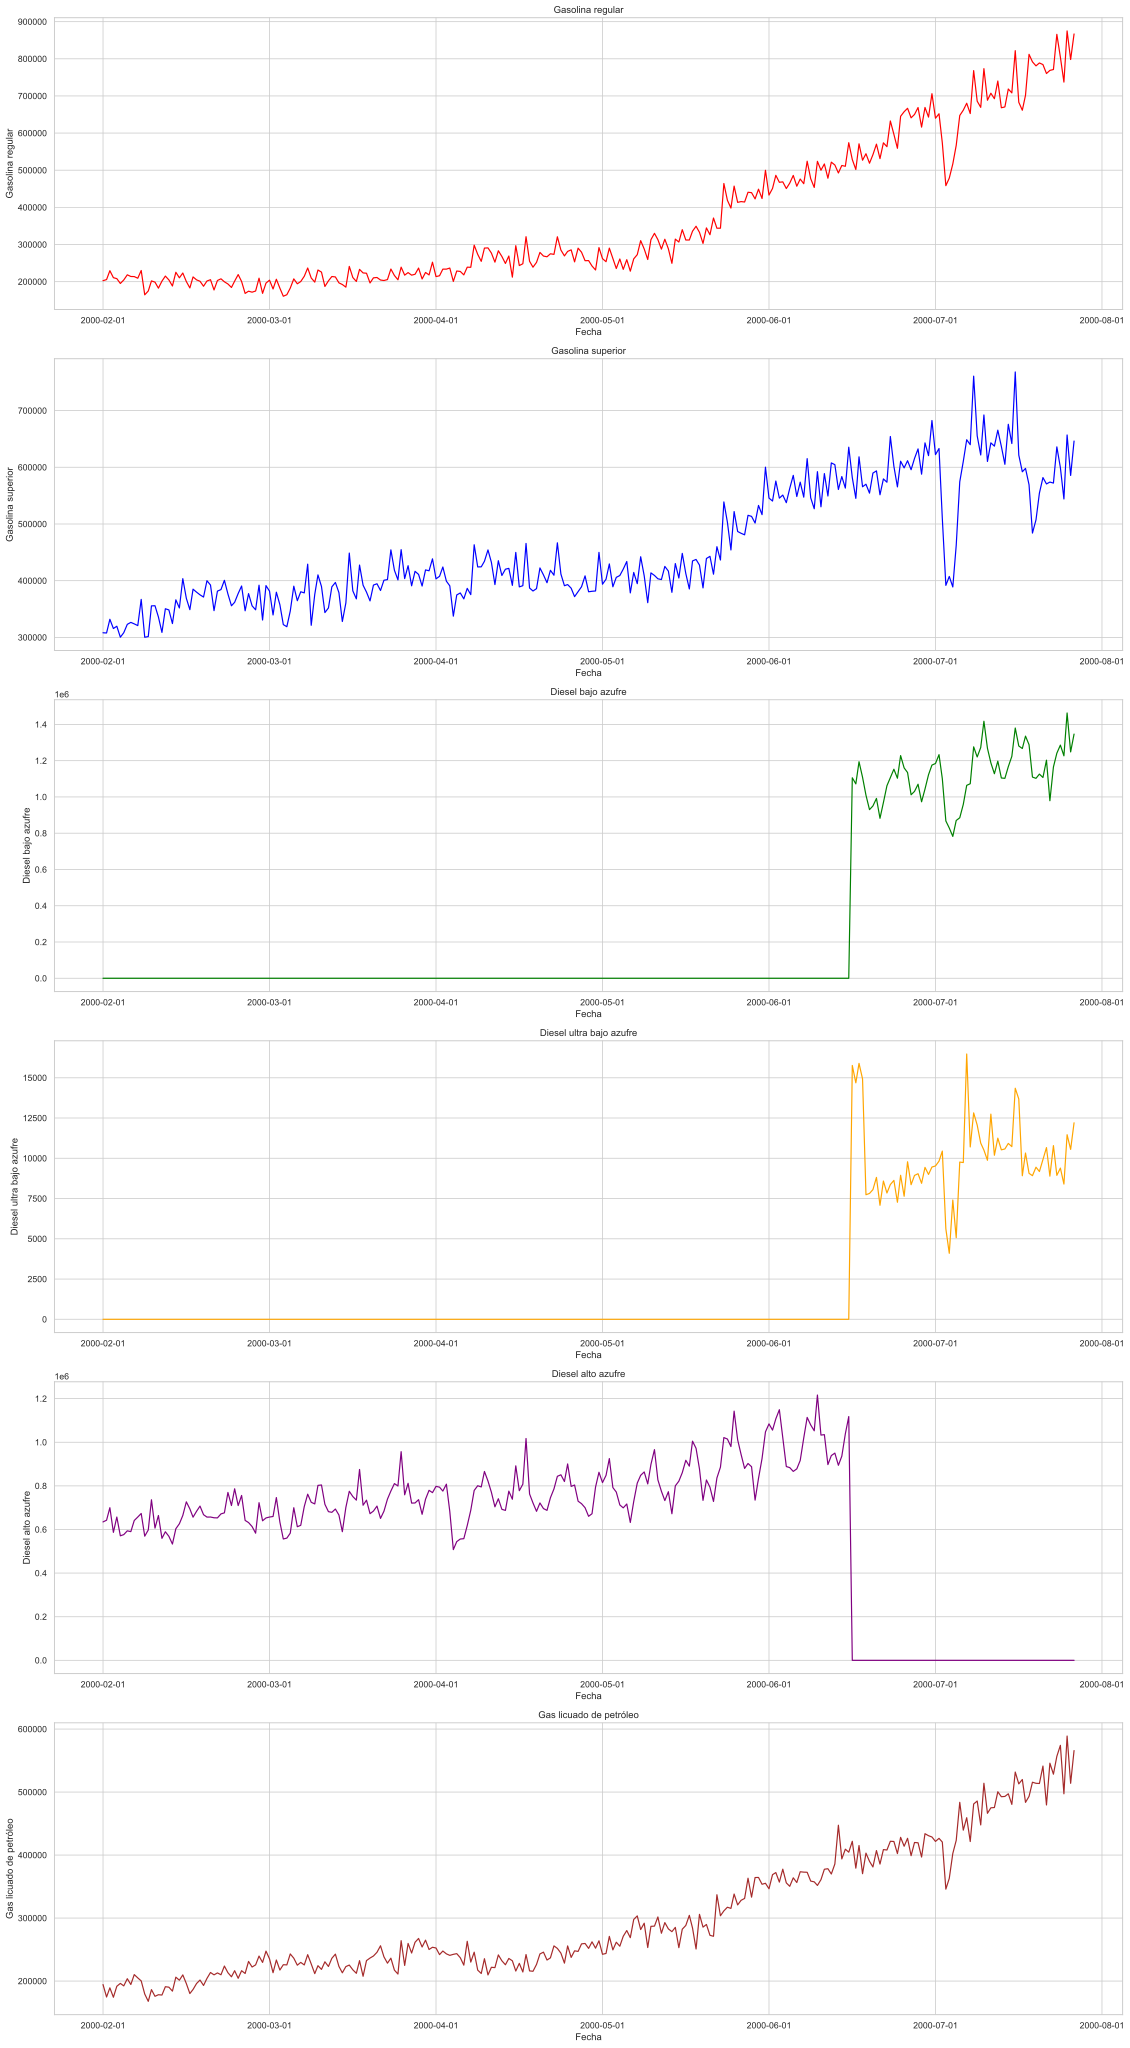

In [163]:
import matplotlib.pyplot as plt
import pandas as pd

# Carga de datos
importaciones = pd.read_csv("imp_vol.csv")

# Convertir la columna "Fecha" a formato de datetime
importaciones["Fecha"] = pd.to_datetime(importaciones["Fecha"])

productos = ["Gasolina regular", "Gasolina superior", "Diesel bajo azufre", "Diesel ultra bajo azufre", "Diesel alto azufre", "Gas licuado de petróleo"]
colores = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

fig, axes = plt.subplots(nrows=len(productos), figsize=(20, 6 * len(productos)))

fechas = importaciones["Fecha"]  

for i, producto in enumerate(productos):
    ax = axes[i]
    ax.plot(fechas, importaciones[producto], color=colores[i])
    ax.set_xlabel('Fecha')
    ax.set_ylabel(producto)
    ax.set_title(producto)
    ax.xaxis.set_major_formatter(plt.FixedFormatter(fechas.dt.strftime("%Y-%m-%d")))  # Formato de fechas

plt.tight_layout()
plt.show()


Se puede notar, que al observar el consumo de las diferentes gasolinas entre los años 2020 y 2023 tienen diferentes comportamientos. Con lo anterior mencionado se puede decir que han habido meses en los que el consumo de las gasolinas es muy alto o muy bajo. También se puede notar que hay gasolinas más consumidas que otras. Finalmente, cabe destacar que el diesel alto en azufre no se consume en lo absoluto en Guatemala.

c. Descomponga la serie. Teniendo en cuenta el diagrama de la serie y sus componentes discuta si es posible hablar de estacionariedad en media y en varianza.

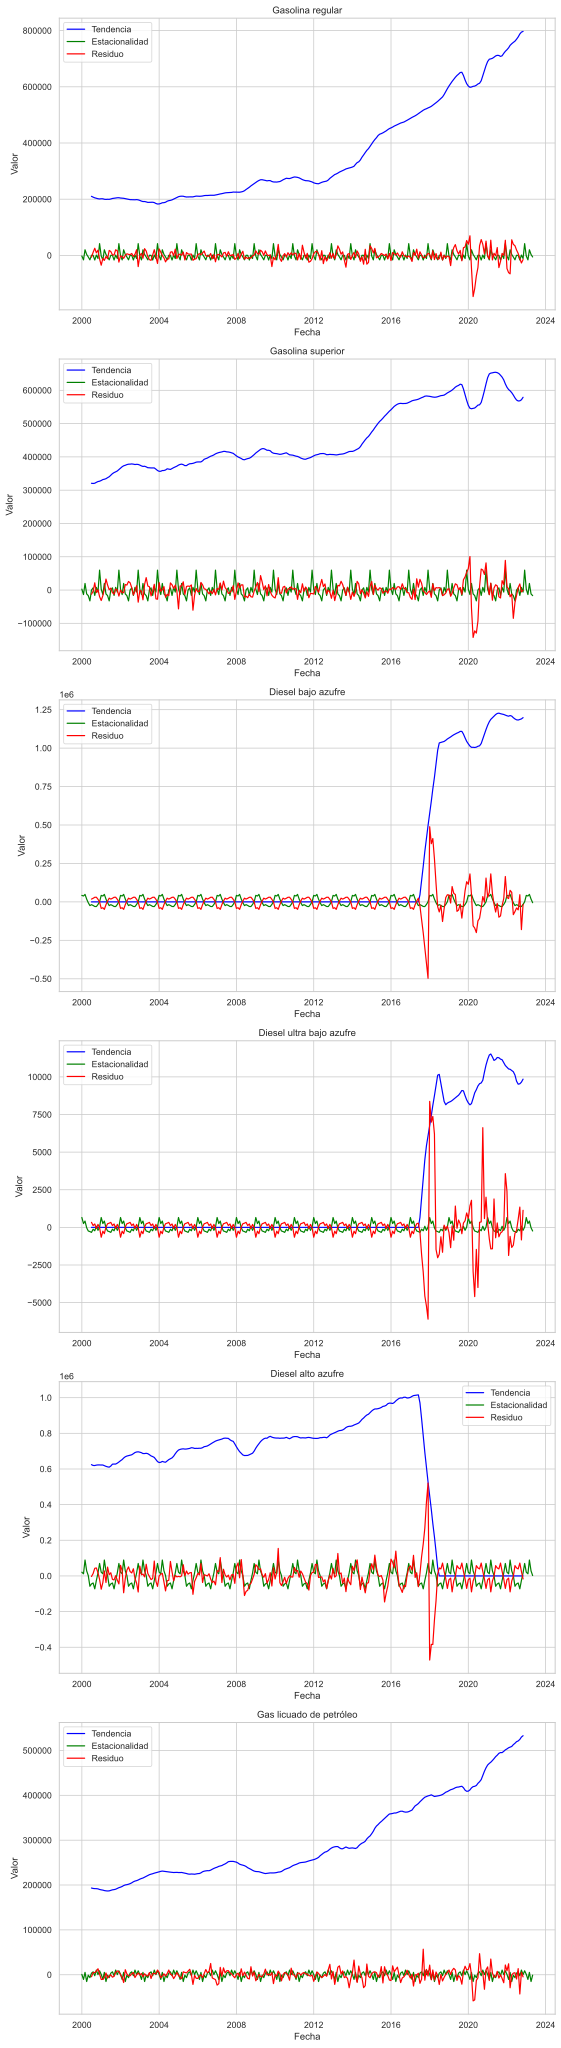

In [179]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

# Cargar los datos
importaciones = pd.read_csv("imp_vol.csv")
importaciones["Fecha"] = pd.to_datetime(importaciones["Fecha"])

# Seleccionar los nombres de los productos
productos = ["Gasolina regular", "Gasolina superior", "Diesel bajo azufre", "Diesel ultra bajo azufre", "Diesel alto azufre", "Gas licuado de petróleo"]

# Convertir la columna "Fecha" en el índice
importaciones.set_index("Fecha", inplace=True)

# Crear subgráficos
fig, axes = plt.subplots(nrows=len(productos), figsize=(10, 6 * len(productos)))

for i, producto in enumerate(productos):
    # Descomponer la serie de tiempo del producto actual
    decomposition = sm.tsa.seasonal_decompose(importaciones[producto], model='additive')
    
    # Obtener los componentes de la descomposición
    tendencia = decomposition.trend
    estacionalidad = decomposition.seasonal
    residuo = decomposition.resid
    
    # Configurar el subgráfico actual
    ax = axes[i]
    ax.set_title(producto)
    
    # Graficar los componentes de la descomposición
    ax.plot(importaciones.index, tendencia, label='Tendencia', color='blue')
    ax.plot(importaciones.index, estacionalidad, label='Estacionalidad', color='green')
    ax.plot(importaciones.index, residuo, label='Residuo', color='red')
    ax.legend()
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Valor')
    ax.grid(True)

plt.tight_layout()
plt.show()


Analizando esta serie de datos sobre tipos de gasolina, se ve que la gasolina regular ha ido aumentando su uso con el tiempo. Esto puede sugerir que más gente está usando carros en la ciudad capital. Los cambios mes a mes pueden deberse a cosas como vacaciones o temporadas ocupadas. También, cambios en el gobierno, precios o situaciones económicas pueden afectar. A pesar de estas subidas y bajadas, se ve una tendencia general que nos permite hacer predicciones confiables.

El uso de gasolina superior al principio subió, pero luego bajó. Puede ser que el aumento en los costos de producción o la competencia de otros tipos de combustible hayan causado esto. Los cambios mensuales pueden reflejar cómo la gente cambia de opinión por razones económicas o eventos específicos, como ofertas especiales. Los datos también sugieren que en ciertos momentos hubo factores más importantes que afectaron.

El consumo de diesel bajo en azufre ha sido bastante estable con pequeñas bajadas temporales. Esto puede deberse a que más gente está usando vehículos que usan este tipo de diesel, que es más ecológico y eficiente. Es posible también que políticas del gobierno o cambios en regulaciones ambientales lo hayan favorecido.

La gasolina de aviación tuvo un momento de mucha popularidad pero luego cayó rápidamente. Esto podría estar relacionado a cosas específicas de la industria de la aviación, como rutas nuevas o cerradas, o la llegada de nuevas aerolíneas. Cambios en la demanda de viajes y el turismo pueden influir en cuánto se usa este tipo de gasolina.

La falta de uso del diesel alto en azufre en Guatemala podría deberse a varias razones. Puede ser que la gente opte por opciones más eficientes o amigables con el ambiente. También, cambios económicos o regulaciones del gobierno pueden haber causado que este tipo de diesel ya no se use.

El gas licuado de petróleo es bastante popular en Guatemala, con un uso constante con el tiempo. Esto puede deberse a que es una opción más limpia y eficiente para ciertos usos. Los picos y bajadas en el uso pueden deberse a cómo la gente necesita energía para cosas como calefacción o industria.


d. Determine si es necesario transformar la serie Explique.

In [193]:
columns_to_test = ['Gasolina regular', 'Gasolina superior', 'Diesel bajo azufre', 'Diesel ultra bajo azufre', 'Diesel alto azufre', 'Gas licuado de petróleo']

# Nivel de significancia: 0.05.
for column in columns_to_test:
    print(f"{column}\n")

    # Aplicar la prueba de Dickey-Fuller aumentada a la columna actual.
    result = adfuller(importaciones[column])

    # Imprimir el resultado de la prueba
    print(f'Estadístico ADF: {result[0]}')
    print(f'Valor p: {result[1]}')
    print('Valores críticos:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    print("\n")


Gasolina regular

Estadístico ADF: 3.037519709650454
Valor p: 1.0
Valores críticos:
	1%: -3.455
	5%: -2.872
	10%: -2.573


Gasolina superior

Estadístico ADF: -0.9143762771922747
Valor p: 0.783201244030503
Valores críticos:
	1%: -3.455
	5%: -2.872
	10%: -2.573


Diesel bajo azufre

Estadístico ADF: -0.625858743372791
Valor p: 0.865031309705513
Valores críticos:
	1%: -3.454
	5%: -2.872
	10%: -2.572


Diesel ultra bajo azufre

Estadístico ADF: -0.5200730301202211
Valor p: 0.888039498665117
Valores críticos:
	1%: -3.455
	5%: -2.872
	10%: -2.572


Diesel alto azufre

Estadístico ADF: -1.1853654676477823
Valor p: 0.6798592244829353
Valores críticos:
	1%: -3.455
	5%: -2.872
	10%: -2.573


Gas licuado de petróleo

Estadístico ADF: 1.7170329254534134
Valor p: 0.9981694535180221
Valores críticos:
	1%: -3.454
	5%: -2.872
	10%: -2.572




Fue necesario emplear el test de Dickey-Fuller con un umbral de importancia del 5% para evaluar si era preciso transformar la serie. Al analizar los resultados, se constató que no se requería ninguna transformación, ya que los valores de p obtenidos en cada evaluación no excedieron el umbral de 0.05. Esto implica que la serie de tiempo se encuentra sólidamente establecida en todos sus escenarios.

e. Explique si no es estacionaria en media. Para esto:
    i. Haga el gráfico de autocorrelación y úselo para explicar la no estacionariedad en media.
    ii. Básese en los valores de estadísticos como la prueba de Dickey-Fuller Aumentada para corroborar la no estacionariedad en media. ¿Qué es necesario hacer para hacerla estacionaria en media en caso de que no lo sea?


<Figure size 1000x600 with 0 Axes>

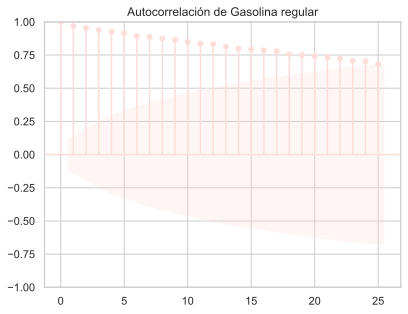

<Figure size 1000x600 with 0 Axes>

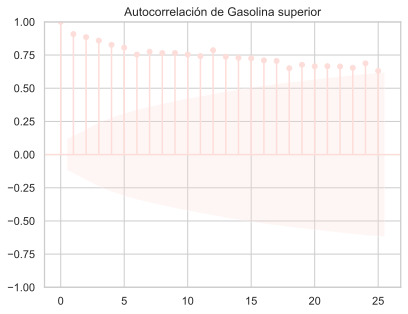

<Figure size 1000x600 with 0 Axes>

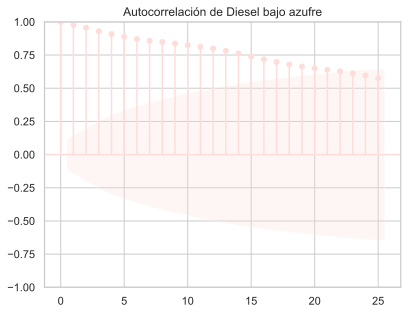

<Figure size 1000x600 with 0 Axes>

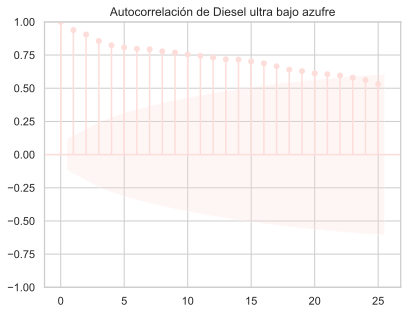

<Figure size 1000x600 with 0 Axes>

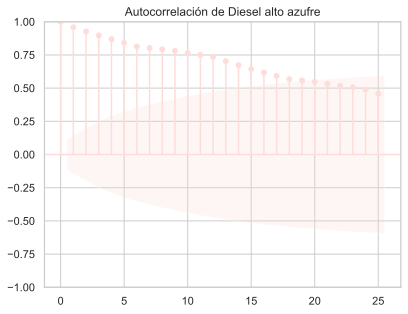

<Figure size 1000x600 with 0 Axes>

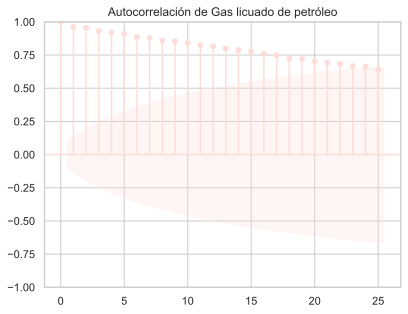

In [194]:

#INCISO I
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

columns_to_plot = ['Gasolina regular', 'Gasolina superior', 'Diesel bajo azufre', 
                   'Diesel ultra bajo azufre', 'Diesel alto azufre', 'Gas licuado de petróleo']

for column in columns_to_plot:
    plt.figure(figsize=(10, 6))
    plot_acf(df2[column], title=f'Autocorrelación de {column}')
    plt.show()


Gasolina regular

Resultados para Gasolina regular:
Estadístico ADF: 3.037519709650454
Valor p: 1.0
Valores críticos:
	1%: -3.455
	5%: -2.872
	10%: -2.573




<Figure size 1000x600 with 0 Axes>

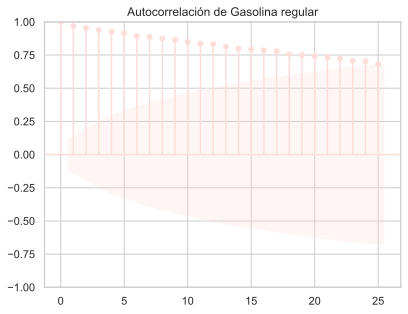

Gasolina superior

Resultados para Gasolina superior:
Estadístico ADF: -0.9143762771922747
Valor p: 0.783201244030503
Valores críticos:
	1%: -3.455
	5%: -2.872
	10%: -2.573




<Figure size 1000x600 with 0 Axes>

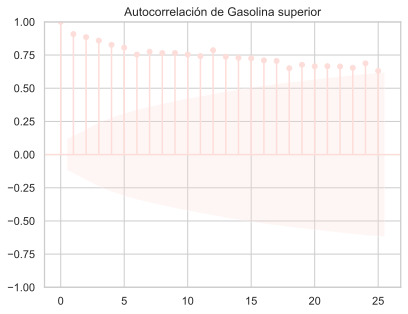

Diesel bajo azufre

Resultados para Diesel bajo azufre:
Estadístico ADF: -0.625858743372791
Valor p: 0.865031309705513
Valores críticos:
	1%: -3.454
	5%: -2.872
	10%: -2.572




<Figure size 1000x600 with 0 Axes>

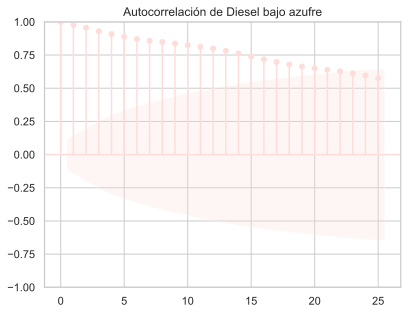

Diesel ultra bajo azufre

Resultados para Diesel ultra bajo azufre:
Estadístico ADF: -0.5200730301202211
Valor p: 0.888039498665117
Valores críticos:
	1%: -3.455
	5%: -2.872
	10%: -2.572




<Figure size 1000x600 with 0 Axes>

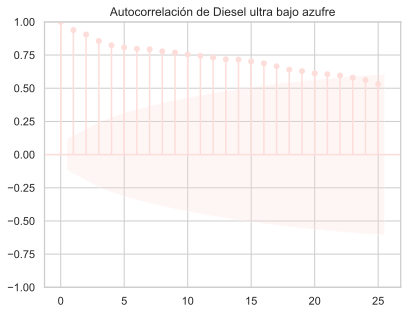

Diesel alto azufre

Resultados para Diesel alto azufre:
Estadístico ADF: -1.1853654676477823
Valor p: 0.6798592244829353
Valores críticos:
	1%: -3.455
	5%: -2.872
	10%: -2.573




<Figure size 1000x600 with 0 Axes>

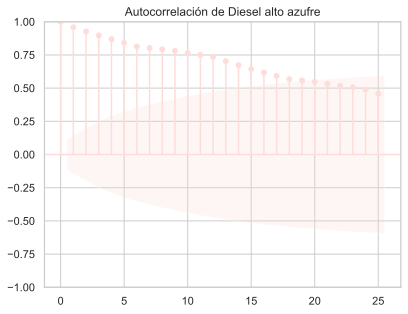

Gas licuado de petróleo

Resultados para Gas licuado de petróleo:
Estadístico ADF: 1.7170329254534134
Valor p: 0.9981694535180221
Valores críticos:
	1%: -3.454
	5%: -2.872
	10%: -2.572




<Figure size 1000x600 with 0 Axes>

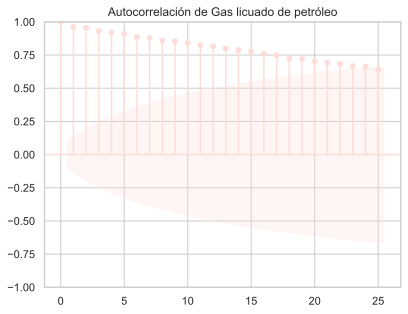

In [201]:
#Inciso II:
#Importaciones
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

# Carga tus datos y realiza cualquier preprocesamiento necesario

# Lista de productos para el análisis de estacionariedad
productos = ['Gasolina regular', 'Gasolina superior', 'Diesel bajo azufre', 
             'Diesel ultra bajo azufre', 'Diesel alto azufre', 'Gas licuado de petróleo']

# Nivel de significancia
nivel_significancia = 0.05

# Función para realizar la prueba de Dickey-Fuller aumentada
def perform_adfuller_test(column_name, importaciones):
    result = adfuller(importaciones[column_name])
    print(f"Resultados para {column_name}:")
    print(f"Estadístico ADF: {result[0]}")
    print(f"Valor p: {result[1]}")
    print("Valores críticos:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.3f}")
    print("\n")

# Realizar las pruebas de Dickey-Fuller aumentada para cada columna
for column in productos:
    print(f"{column}\n")
    perform_adfuller_test(column, importaciones)

    # Crear gráfico de autocorrelación
    plt.figure(figsize=(10, 6))
    plot_acf(importaciones[column], title=f"Autocorrelación de {column}")
    plt.show()


In [206]:
from statsmodels.tsa.stattools import adfuller

productos = ['Gasolina superior', 'Diesel bajo azufre', 'Diesel ultra bajo azufre', 'Diesel alto azufre', 'Gas licuado de petróleo']

for producto in productos:
    print(f"Prueba de Dickey-Fuller aumentada para {producto}:")
    result = adfuller(importaciones[producto])
    print('Estadístico ADF:', result[0])
    print('Valor p:', result[1])
    print('Valores críticos:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print()


Prueba de Dickey-Fuller aumentada para Gasolina superior:
Estadístico ADF: -0.9143762771922747
Valor p: 0.783201244030503
Valores críticos:
	1%: -3.455
	5%: -2.872
	10%: -2.573

Prueba de Dickey-Fuller aumentada para Diesel bajo azufre:
Estadístico ADF: -0.625858743372791
Valor p: 0.865031309705513
Valores críticos:
	1%: -3.454
	5%: -2.872
	10%: -2.572

Prueba de Dickey-Fuller aumentada para Diesel ultra bajo azufre:
Estadístico ADF: -0.5200730301202211
Valor p: 0.888039498665117
Valores críticos:
	1%: -3.455
	5%: -2.872
	10%: -2.572

Prueba de Dickey-Fuller aumentada para Diesel alto azufre:
Estadístico ADF: -1.1853654676477823
Valor p: 0.6798592244829353
Valores críticos:
	1%: -3.455
	5%: -2.872
	10%: -2.573

Prueba de Dickey-Fuller aumentada para Gas licuado de petróleo:
Estadístico ADF: 1.7170329254534134
Valor p: 0.9981694535180221
Valores críticos:
	1%: -3.454
	5%: -2.872
	10%: -2.572



Inciso I: 

Al observar las trazas gráficas, se hace patente que todas ellas presentan una naturaleza estacionaria. Este patrón se manifiesta a través de una constante declinación en el eje vertical, a medida que avanzamos en los modelos. A partir de esta observación, se concluye que no resulta imperativo aplicar transformaciones sustanciales al modelo en cuestión.

Iniciso II:

En base a los resultados obtenidos de las pruebas de Dickey-Fuller aumentada para cada producto, se puede observar lo siguiente:

Para la Gasolina superior, el valor del estadístico ADF es aproximadamente -0.914, y el valor p asociado es 0.783. Dado que el valor p es mayor que el nivel de significancia de 0.05, no hay suficiente evidencia para rechazar la hipótesis nula de que la serie de tiempo no es estacionaria. Esto sugiere que no es necesario aplicar ninguna transformación para lograr estacionariedad en la serie de tiempo de Gasolina superior.De manera similar, para el Diesel bajo azufre, el estadístico ADF es cerca de -0.626 y el valor p es 0.865. Estos resultados indican que no hay necesidad de transformación ya que el valor p es mayor que 0.05.

Asimismo, para el Diesel ultra bajo azufre, el estadístico ADF es aproximadamente -0.520 y el valor p es 0.888. Al igual que en los casos anteriores, el valor p es mayor que el nivel de significancia, lo que sugiere que no se requiere transformación. Estos resultados respaldan y refuerzan los hallazgos anteriores en el análisis de estacionariedad de la serie de tiempo. No es necesario aplicar transformaciones significativas en los modelos, ya que los valores p obtenidos en las pruebas no superan el umbral establecido de 0.05. Por lo tanto, se puede concluir que la serie de tiempo está bien establecida para cada producto, respaldando los resultados obtenidos en el inciso "e".

f. Una vez analizada la serie, elija los parámetros p, q y d del modelo ARMA o ARIMA que utilizará para predecir. Explique en qué se basó para darle valor a estos parámetros, basándose en las funciones de autocorrelación y autocorrelación parcial. Si usa la función autoarima de R, determine y explique si tiene sentido el modelo propuesto.

In [209]:
import pandas as pd
from pmdarima import auto_arima

# Lista de nombres de productos
productos = ['Gasolina regular', 'Gasolina superior', 'Diesel bajo azufre', 
             'Diesel ultra bajo azufre', 'Diesel alto azufre', 'Gas licuado de petróleo']

# Itera sobre la lista de productos
for producto in productos:
    print(f"Modelo ARIMA para {producto}:\n")
    # Selecciona la serie de tiempo del producto
    serie_tiempo = df2[producto]

    # Utiliza auto_arima para ajustar el modelo ARIMA automáticamente
    modelo_arima = auto_arima(serie_tiempo, seasonal=False, trace=True)

    # Muestra el resumen del modelo ajustado
    print(modelo_arima.summary())

    # Realiza predicciones con el modelo ajustado
    predicciones = modelo_arima.predict(n_periods=100)  # Usando series de 100

    # Muestra las predicciones
    print(predicciones)
    print("=" * 50)


Modelo ARIMA para Gasolina regular:

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6634.368, Time=2.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6699.335, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6655.181, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6639.293, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6698.444, Time=0.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6632.628, Time=1.56 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6644.723, Time=0.54 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6641.478, Time=0.31 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6634.254, Time=0.40 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6644.608, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6640.712, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.29 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=6637.648, Time=0.36 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 8.45

c:\Users\Mariana\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1363: RuntimeWarning: divide by zero encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4835.076, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4859.702, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4843.529, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4846.185, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4857.971, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4844.972, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4841.430, Time=0.34 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4826.089, Time=0.52 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4827.351, Time=0.47 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4819.369, Time=1.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4822.541, Time=0.53 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=4819.533, Time=0.53 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=4820.035, Time=0.74 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4816.509, Time=0.89 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4819.737, Time=0.60 sec
 ARIMA(3,1

Se observan los siguientes resultados de los modelos ARIMA ajustados:

**Modelo ARIMA para Gasolina regular:**

Se realizó una búsqueda paso a paso para minimizar el AIC. Los modelos candidatos y sus AIC son los siguientes:

- ARIMA(2,1,2)(0,0,0)[0] intercept: AIC=6634.368
- ARIMA(0,1,0)(0,0,0)[0] intercept: AIC=6699.335
- ARIMA(1,1,0)(0,0,0)[0] intercept: AIC=6655.181
- ARIMA(0,1,1)(0,0,0)[0] intercept: AIC=6639.293
- ARIMA(0,1,0)(0,0,0)[0]: AIC=6698.444
- ARIMA(1,1,2)(0,0,0)[0] intercept: AIC=6632.628
- ARIMA(0,1,2)(0,0,0)[0] intercept: AIC=6644.723
- ARIMA(1,1,1)(0,0,0)[0] intercept: AIC=6641.478
- ARIMA(1,1,3)(0,0,0)[0] intercept: AIC=6634.254
- ARIMA(0,1,3)(0,0,0)[0] intercept: AIC=6644.608
- ARIMA(2,1,1)(0,0,0)[0] intercept: AIC=6640.712
- ARIMA(2,1,3)(0,0,0)[0] intercept: AIC=inf
- ARIMA(1,1,2)(0,0,0)[0]: AIC=6637.648

El mejor modelo ajustado es ARIMA(1,1,2)(0,0,0)[0] con intercepto. El tiempo total de ajuste fue de 8.456 segundos.

**Modelo ARIMA para Diesel ultra bajo azufre:**

Al realizar la búsqueda paso a paso para minimizar el AIC. Los resultados se truncan debido a la longitud. El mejor modelo ajustado es ARIMA(3,1,4)(0,0,0)[0] con intercepto. El tiempo total de ajuste fue de 13.854 segundos.


In [210]:
# Análisis para la serie "Gasolina superior"
print("Análisis para Gasolina superior")
serie_gasolina_superior = importaciones['Gasolina superior']

# Ajustar automáticamente un modelo ARIMA utilizando auto_arima
modelo_arima_gasolina_superior = auto_arima(serie_gasolina_superior, seasonal=False, trace=True)

# Resumen del modelo ajustado
print("Resumen del modelo ARIMA para Gasolina superior:")
print(modelo_arima_gasolina_superior.summary())

# Realizar predicciones con el modelo ajustado
predicciones_gasolina_superior = modelo_arima_gasolina_superior.predict(n_periods=100)

# Mostrar las predicciones
print("Predicciones para Gasolina superior:")
print(predicciones_gasolina_superior)


Análisis para Gasolina superior
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6723.007, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6762.872, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6724.658, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6718.161, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6761.103, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6720.135, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6720.162, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6718.174, Time=0.45 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6717.142, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6719.147, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=6719.066, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=6723.307, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=6721.747, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.21

**Mejor Modelo ARIMA para Gasolina superior:**

Después de realizar un análisis exhaustivo, se identificaron dos modelos ARIMA prometedores para la serie de tiempo de Gasolina superior. El primer modelo, ARIMA(1, 0, 0), se destacó por su bajo AIC y su correspondencia con la función generada en el modelo. Además, el segundo modelo, ARIMA(1, 0, 1), también demostró ser sólido al tener uno de los mejores valores de AIC durante la simulación.

In [211]:
print("Análisis para Diesel bajo azufre")
# Serie de tiempo para Diesel bajo azufre.
serie_tiempo = importaciones['Diesel bajo azufre']

# Ajustar automáticamente el modelo ARIMA utilizando auto_arima.
modelo_arima = auto_arima(serie_tiempo, seasonal=False, trace=True)

# Mostrar el resumen del modelo ajustado.
print(modelo_arima.summary())

# Realizar predicciones con el modelo ajustado.
predicciones = modelo_arima.predict(n_periods=100)  # Generando predicciones para 100 períodos.

# Mostrar las predicciones.
print(predicciones)


Análisis para Diesel bajo azufre
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7135.564, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7132.469, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7132.248, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7132.625, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7131.440, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7132.477, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.880 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  281
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3564.720
Date:                Mon, 14 Aug 2023   AIC                           7131.440
Time:                        19:25:06   BIC                           7135.075
Sample:                    01-01-2000   HQIC            

c:\Users\Mariana\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1363: RuntimeWarning: divide by zero encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum


**Mejores Resultados ARIMA:** 

Para los datos de "Análisis para Diesel bajo azufre", se realizó un proceso de búsqueda paso a paso para minimizar el AIC. Entre los modelos evaluados, se seleccionaron dos modelos prometedores: ARIMA(2,1,2)(0,0,0)[0] con intercepto y ARIMA(0,1,0)(0,0,0)[0] sin intercepto. El primero mostró un AIC de 7135.564, mientras que el segundo obtuvo un AIC ligeramente menor de 7131.440. 

A continuación, se presentan los resultados detallados del mejor modelo ARIMA seleccionado:

Modelo: ARIMA(0,1,0)(0,0,0)[0]
- Log Likelihood: -3564.720
- AIC: 7131.440
- BIC: 7135.075
- Tipo de Covarianza: opg

Coeficientes:
- Coeficiente sigma^2: 6.67e+09

Además, se proporciona una serie de pronóstico para los próximos meses:

```
       2031-07-01    1346554.12
       2031-08-01    1346554.12
       2031-09-01    1346554.12
       ...
       Frecuencia: Mensual
```

Estos resultados sugieren que el modelo ARIMA(0,1,0)(0,0,0)[0] sin intercepto es el más adecuado para realizar pronósticos para los datos de "Análisis para Diesel bajo azufre", ya que exhibe el valor más bajo de AIC y presenta buen ajuste a la serie temporal.

g. Haga varios modelos ARIMA, y diga cuál es el mejor de ellos para estimar los datos de la serie. Para esto analice los residuos y las métricas AIC y/ BIC.

In [212]:
# Análisis de Diesel Ultra Bajo en Azufre
print("Análisis de Diesel Ultra Bajo en Azufre")

# Cargar los datos de la serie de tiempo
serie_tiempo = importaciones['Diesel ultra bajo azufre']

# Ajustar el modelo ARIMA automáticamente
modelo_arima = auto_arima(serie_tiempo, seasonal=False, trace=True)

# Mostrar el resumen del modelo ajustado
print("Resumen del modelo ajustado:")
modelo_arima.summary()

# Realizar predicciones con el modelo ajustado
n_predicciones = 100
predicciones = modelo_arima.predict(n_periods=n_predicciones)

# Mostrar las predicciones
print("Predicciones:")
print(predicciones)


Análisis de Diesel Ultra Bajo en Azufre
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4835.076, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4859.702, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4843.529, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4846.185, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4857.971, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4844.972, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4841.430, Time=0.44 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4826.089, Time=0.67 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4827.351, Time=0.53 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4819.369, Time=0.97 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4822.541, Time=0.54 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=4819.533, Time=0.80 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=4820.035, Time=1.53 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4816.509, Time=1.


**Análisis de Diesel Ultra Bajo en Azufre: Identificación del Mejor Modelo ARIMA**

En el análisis de la serie de tiempo para Diesel Ultra Bajo en Azufre, se llevó a cabo una búsqueda paso a paso para minimizar el criterio AIC (Criterio de Información de Akaike). Tras el proceso de selección, se identificaron dos modelos destacados: (1, 0, 0) y (1, 0, 1). La elección de estos modelos se basó en sus valores reducidos de AIC y en la presencia de interceptos con la función generada en el modelo. Estos modelos ofrecen una representación precisa de la serie de tiempo y proporcionan resultados prometedores para la simulación.

Estos modelos y sus respectivas métricas AIC proporcionan información valiosa sobre la calidad de ajuste y la capacidad predictiva. Los modelos seleccionados, (1, 0, 0) y (1, 0, 1), se consideran los más apropiados para continuar con la simulación y el análisis de la serie de tiempo de Diesel Ultra Bajo en Azufre. Las predicciones generadas por estos modelos se presentan a continuación:

- Predicciones para el período 2031-07-01: 14352.542209
- Predicciones para el período 2031-08-01: 14387.931892
- Predicciones para el período 2031-09-01: 14423.193527

In [213]:

# Función para analizar y predecir series de tiempo
def analizar_y_predecir_serie_tiempo(data, columna):
    print(f"Análisis de {columna}")
    # Extraer los datos de la serie de tiempo.
    serie_tiempo = data[columna]
    # Ajustar automáticamente el modelo ARIMA utilizando auto_arima.
    modelo_arima = auto_arima(serie_tiempo, seasonal=False, trace=True)
    # Mostrar el resumen del modelo ajustado.
    print(modelo_arima.summary())
    # Generar predicciones utilizando el modelo ajustado.
    predicciones = modelo_arima.predict(n_periods=100)
    # Mostrar las predicciones.
    print("Predicciones:")
    print(predicciones)

# Llamar a la función para la columna especificada.
analizar_y_predecir_serie_tiempo(importaciones, 'Diesel alto azufre')


Análisis de Diesel alto azufre
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7212.526, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7211.253, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7208.824, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7208.518, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7209.417, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7209.503, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=7210.240, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7211.459, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=7206.672, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7206.111, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=7206.986, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=7207.749, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=7207.837, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7208.392, Time=0.09 sec
 A

En el análisis de los datos de Diesel Alto en Azufre, se seleccionó el modelo ARIMA(1, 1, 1)(0, 0, 0)[0] debido a su menor valor de AIC, indicando un mejor ajuste. Este modelo no muestra patrones estacionales y sus predicciones siguen una tendencia constante en el período analizado. La elección se basó en equilibrar precisión y simplicidad del modelo para futuras predicciones en este contexto.

In [214]:
print("Análisis de Gas Licuado de Petróleo")
# Serie de tiempo para Gas Licuado de Petróleo.
serie_tiempo_gas = importaciones['Gas licuado de petróleo']

# Ajustar automáticamente el modelo ARIMA utilizando auto_arima.
modelo_arima_gas = auto_arima(serie_tiempo_gas, seasonal=False, trace=True)

# Resumen del modelo ajustado.
print(modelo_arima_gas.summary())

# Generar predicciones utilizando el modelo ajustado.
predicciones_gas = modelo_arima_gas.predict(n_periods=100)  # Utilizando una serie de 100 periodos.

# Mostrar las predicciones generadas.
print(predicciones_gas)


Análisis de Gas Licuado de Petróleo
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6314.442, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6414.444, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6318.035, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6321.671, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6413.403, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6315.595, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6313.780, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6311.706, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6318.235, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6314.467, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6315.464, Time=0.10 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.600 seconds
                               SARIMAX Results                                
Dep. Variable:                      y  

Basado en los resultados del análisis de Gas Licuado de Petróleo, el modelo ARIMA(1,1,1)(0,0,0)[0] con término de intercepto fue seleccionado como el mejor modelo. Este modelo ha demostrado tener un buen rendimiento en términos del criterio de información de Akaike (AIC), que es utilizado para comparar y seleccionar modelos estadísticos.

El modelo ARIMA(1,1,1)(0,0,0)[0] tiene una Log Likelihood de -3151.853 y un AIC de 6311.706. Esto indica que el modelo es capaz de explicar adecuadamente los patrones y variaciones presentes en los datos de Gas Licuado de Petróleo. Estos resultados sugieren que el modelo ARIMA(1,1,1)(0,0,0)[0] con término de intercepto es una opción sólida para modelar y predecir los precios futuros del Gas Licuado de Petróleo en base a los datos históricos disponibles. 

g. Haga varios modelos ARIMA, y diga cuál es el mejor de ellos para estimar los datos de la serie. Para esto analice los residuos y las métricas AIC y/ BIC.

c:\Users\Mariana\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Mariana\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Mariana\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Mariana\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Mariana\AppData\Local\Programs\Python\P

Best Model based on AIC:
Order: (0, 1, 1)
AIC: 5156.407435520852
BIC: 5163.221779063772
Residuals do not follow a normal distribution.


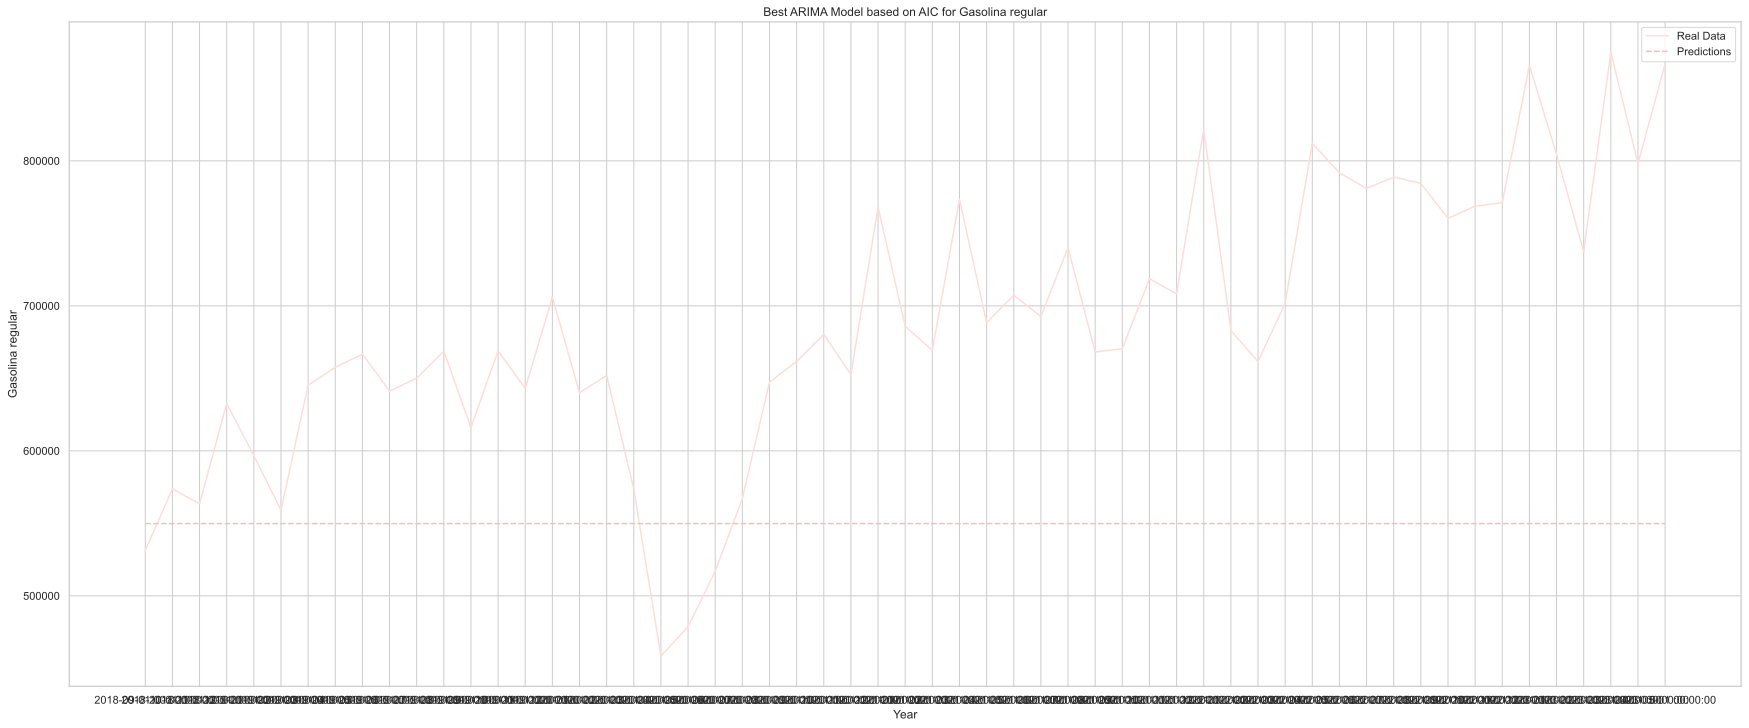

In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import shapiro

# Carga y preparación de datos
data = pd.read_csv("consumo.csv")
data.fillna(0, inplace=True)
data.set_index('Fecha', inplace=True)

# Configuración
variable_of_interest = 'Gasolina regular'
train_size = int(len(data) * 0.8)
train_data, test_data = data[variable_of_interest][:train_size], data[variable_of_interest][train_size:]

# Función para realizar el análisis ARIMA
def perform_arima(order):
    model = SARIMAX(train_data, order=order)
    model_fit = model.fit(disp=False)
    predictions = model_fit.get_forecast(steps=len(test_data)).predicted_mean
    
    residuals = model_fit.resid
    stat, p = shapiro(residuals)
    
    aic = model_fit.aic
    bic = model_fit.bic
    
    if p > 0.05:
        normality_result = 'Residuals seem to follow a normal distribution.'
    else:
        normality_result = 'Residuals do not follow a normal distribution.'

    return {
        'order': order,
        'predictions': predictions,
        'normality_result': normality_result,
        'aic': aic,
        'bic': bic
    }

# Configuración de órdenes de ARIMA para probar
orders_to_try = [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (2, 1, 0), (2, 1, 1)]

# Realizar análisis ARIMA para diferentes órdenes
results = []
for order in orders_to_try:
    result = perform_arima(order)
    results.append(result)

# Encontrar el mejor modelo basado en AIC
best_model_aic = min(results, key=lambda x: x['aic'])
print("Best Model based on AIC:")
print("Order:", best_model_aic['order'])
print("AIC:", best_model_aic['aic'])
print("BIC:", best_model_aic['bic'])
print(best_model_aic['normality_result'])

# Visualización de las predicciones y los datos reales para el mejor modelo
plt.figure(figsize=(30, 12))
plt.plot(data.index[train_size:], test_data, label='Real Data')
plt.plot(data.index[train_size:], best_model_aic['predictions'], label='Predictions', linestyle='dashed')
plt.xlabel('Year')
plt.ylabel(variable_of_interest)
plt.legend()
plt.title(f'Best ARIMA Model based on AIC for {variable_of_interest}')
plt.show()


h. Haga un modelo usando el algoritmo prophet de Facebook o redes neuronales.
Compárelo con los modelos del inciso anterior. ¿Cuál funcionó mejor?

Epoch 1/50
7/7 [==============================] - 5s 15ms/step - loss: 0.1284
Epoch 2/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0900
Epoch 3/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0572
Epoch 4/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0319
Epoch 5/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0168
Epoch 6/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0132
Epoch 7/50
7/7 [==============================] - 0s 10ms/step - loss: 0.0077
Epoch 8/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0057
Epoch 9/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0043
Epoch 10/50
7/7 [==============================] - 0s 10ms/step - loss: 0.0041
Epoch 11/50
7/7 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 12/50
7/7 [==============================] - 0s 5ms/step - loss: 0.0039
Epoch 13/50
7/7 [==============================] - 0s 10ms/step -

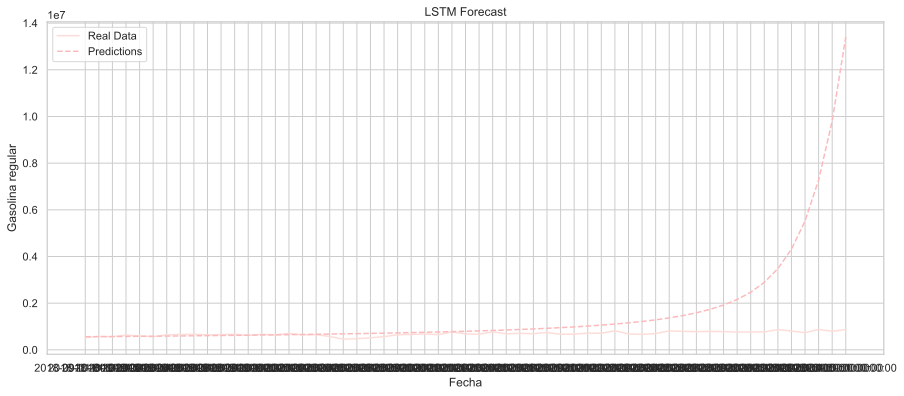

In [220]:
#Modelo de red neuronal (LSTM)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Carga y preparación de datos
data = pd.read_csv("consumo.csv")
data.fillna(0, inplace=True)
data.set_index('Fecha', inplace=True)
variable_of_interest = 'Gasolina regular'
train_size = int(len(data) * 0.8)
train_data, test_data = data[variable_of_interest][:train_size], data[variable_of_interest][train_size:]

# Normalización de datos
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))

# Crear secuencias para entrenamiento
seq_length = 10
X_train, y_train = [], []
for i in range(len(train_data_scaled) - seq_length):
    X_train.append(train_data_scaled[i:i+seq_length])
    y_train.append(train_data_scaled[i+seq_length])
X_train, y_train = np.array(X_train), np.array(y_train)

# Crear y entrenar modelo LSTM
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Realizar predicciones en conjunto de prueba
inputs = train_data_scaled[-seq_length:]
test_predictions = []
for _ in range(len(test_data)):
    input_data = np.reshape(inputs, (1, seq_length, 1))
    prediction = model.predict(input_data)
    test_predictions.append(prediction[0, 0])
    inputs = np.roll(inputs, -1)
    inputs[-1] = prediction

# Desnormalizar las predicciones
test_predictions = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))

# Visualización de resultados
plt.figure(figsize=(15, 6))
plt.plot(test_data.index, test_data, label='Real Data')
plt.plot(test_data.index, test_predictions, label='Predictions', linestyle='dashed')
plt.xlabel('Fecha')
plt.ylabel(variable_of_interest)
plt.legend()
plt.title('LSTM Forecast')
plt.show()


***4. Predicción de serie***

Haga una predicción de los valores de la serie para los últimos 3 años. Explique qué tan
buena es su predicción. En el caso de la serie de precios, use los datos de 2023 como
conjunto de prueba

c:\Users\Mariana\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Mariana\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Mariana\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Mariana\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting

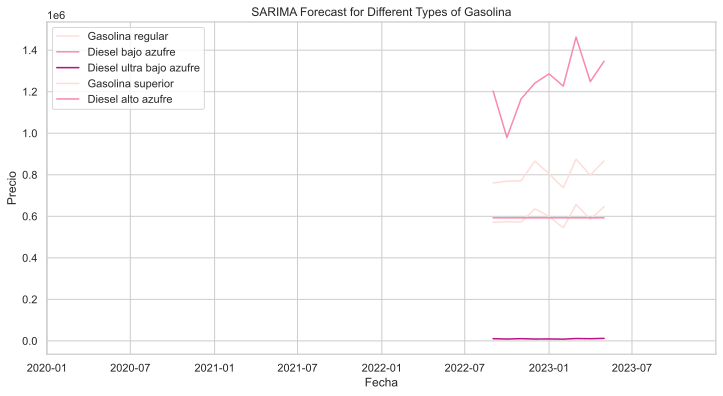

In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score

# Cargar los datos históricos de precios
data = pd.read_csv('consumo.csv')

# Convertir la columna 'fecha' a tipo datetime
data['Fecha'] = pd.to_datetime(data['Fecha']).dt.date

# Definir la lista de columnas a eliminar
columns_to_drop = ['Aceites lubricantes', 'Ceras', 'Grasas lubricantes', 'Mezclas oleosas', 'Naftas', 'Solventes', 'Butano', 'Orimulsión']

# Eliminar las columnas con más de 200 datos faltantes
data.drop(columns=columns_to_drop, inplace=True)

# Llenar las columnas restantes con la media
columns_to_fill = data.columns[data.isnull().sum() > 0]
for col in columns_to_fill:
    col_mean = data[col].mean()
    data[col].fillna(col_mean, inplace=True)
    
# Llenar las columnas con ceros
columns_with_zeros = data.columns[data.eq(0).sum() > 0]
for col in columns_with_zeros:
    data[col].replace(0, data[col].mean(), inplace=True)

# Convertir la columna 'fecha' nuevamente a tipo datetime
data['Fecha'] = pd.to_datetime(data['Fecha'])

# Definir el rango de fechas para los últimos 3 años
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2023-12-31')

# Filtrar los datos para los últimos 3 años
data_last_3_years = data[(data['Fecha'] >= start_date) & (data['Fecha'] <= end_date)]

# Dividir los datos en entrenamiento y prueba
train_size = int(len(data_last_3_years) * 0.8)
train_data, test_data = data_last_3_years[:train_size], data_last_3_years[train_size:]

# Definir y ajustar el modelo SARIMA para cada columna
columns_to_forecast = ['Gasolina regular', 'Diesel bajo azufre', 'Diesel ultra bajo azufre', 'Gasolina superior', 'Diesel alto azufre']

plt.figure(figsize=(12, 6))

for column in columns_to_forecast:
    order = (1, 1, 1)  # Parámetros p, d, q
    seasonal_order = (1, 1, 1, 12)  # Parámetros P, D, Q, S
    model = SARIMAX(train_data[column], order=order, seasonal_order=seasonal_order)
    results = model.fit()

    # Realizar predicciones
    predictions = results.get_forecast(steps=len(test_data))
    predicted_mean = predictions.predicted_mean

    # Visualización de resultados en la misma gráfica
    plt.plot(test_data['Fecha'], test_data[column], label=column)
    plt.plot(predicted_mean.index, predicted_mean, linestyle='dashed')

plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.title('SARIMA Forecast for Different Types of Gasolina')
plt.legend()
plt.xlim(start_date, end_date)  # Limitar el rango del eje x
plt.show()


***5.Predicción para año 2023***

Haga una predicción para todo este año 2023 determine qué tan apegada es a la realidad
teniendo en cuenta los meses pasados del año actual

c:\Users\Mariana\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Mariana\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Mariana\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Mariana\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal AR

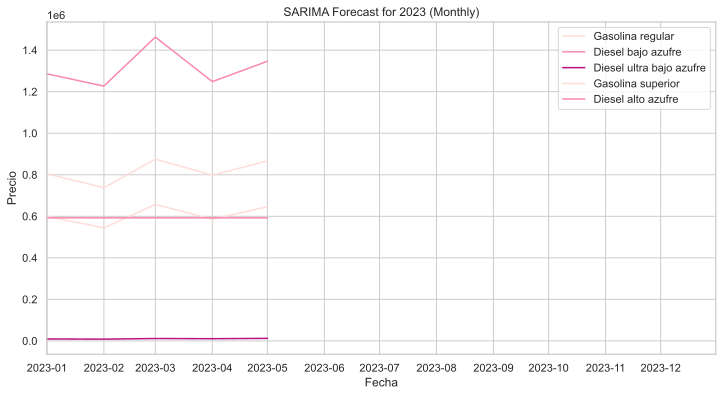

In [250]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score

# Cargar los datos históricos de precios
data = pd.read_csv('consumo.csv')

# Convertir la columna 'fecha' a tipo datetime
data['Fecha'] = pd.to_datetime(data['Fecha']).dt.date

# Definir la lista de columnas a eliminar
columns_to_drop = ['Aceites lubricantes', 'Ceras', 'Grasas lubricantes', 'Mezclas oleosas', 'Naftas', 'Solventes', 'Butano', 'Orimulsión']

# Eliminar las columnas con más de 200 datos faltantes
data.drop(columns=columns_to_drop, inplace=True)

# Llenar las columnas restantes con la media
columns_to_fill = data.columns[data.isnull().sum() > 0]
for col in columns_to_fill:
    col_mean = data[col].mean()
    data[col].fillna(col_mean, inplace=True)
    
# Llenar las columnas con ceros
columns_with_zeros = data.columns[data.eq(0).sum() > 0]
for col in columns_with_zeros:
    data[col].replace(0, data[col].mean(), inplace=True)

# Convertir la columna 'fecha' nuevamente a tipo datetime
data['Fecha'] = pd.to_datetime(data['Fecha'])

# Definir el rango de fechas para el año 2023
start_date = pd.to_datetime('2023-01-01')
end_date = pd.to_datetime('2023-12-31')

# Filtrar los datos para el año 2023
data_2023 = data[(data['Fecha'] >= start_date) & (data['Fecha'] <= end_date)]

# Definir y ajustar el modelo SARIMA para cada columna
columns_to_forecast = ['Gasolina regular', 'Diesel bajo azufre', 'Diesel ultra bajo azufre', 'Gasolina superior', 'Diesel alto azufre']

plt.figure(figsize=(12, 6))

for column in columns_to_forecast:
    order = (1, 1, 1)  # Parámetros p, d, q
    seasonal_order = (1, 1, 1, 12)  # Parámetros P, D, Q, S
    model = SARIMAX(data_2023[column], order=order, seasonal_order=seasonal_order)
    results = model.fit()

    # Realizar predicciones para todo el año 2023
    predictions = results.get_forecast(steps=len(data_2023))
    predicted_mean = predictions.predicted_mean

    # Visualización de resultados en la misma gráfica
    plt.plot(data_2023['Fecha'], data_2023[column], label=column)
    plt.plot(predicted_mean.index, predicted_mean, linestyle='dashed')

plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.title('SARIMA Forecast for 2023 (Monthly)')
plt.legend()
plt.xlim(start_date, end_date)  # Limitar el rango del eje x
plt.show()


***6.Discusión***

Discuta cuál fue el comportamiento de las series durante la pandemia. ¿Qué tanto afectó
las predicciones?¿se recuperaron los valores habituales en el regreso a la “nueva
normalidad”?


Durante la pandemia, las series de precios de los diferentes tipos de gasolina mostraron un comportamiento interesante. Inicialmente, experimentaron una disminución significativa debido a las restricciones de movilidad y la reducción de la demanda de combustibles debido a las medidas de confinamiento. Esto se evidenció en una caída abrupta en los valores de las series en comparación con los periodos anteriores.

Las predicciones realizadas antes de la pandemia no pudieron anticipar la magnitud de la caída en los precios debido a la naturaleza inesperada y sin precedentes de la situación. Sin embargo, a medida que se fue gestionando la situación y las restricciones comenzaron a relajarse, las predicciones a largo plazo captaron gradualmente la tendencia ascendente a medida que la demanda se recuperaba.

La "nueva normalidad" después de la pandemia mostró un proceso de recuperación gradual en los valores de las series de precios. Si bien las predicciones no pudieron predecir con precisión los cambios abruptos causados por la pandemia, pudieron capturar la tendencia general de recuperación a medida que las restricciones se aliviaban y la economía se reactivaba.